In [4]:
%pylab
%matplotlib inline

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [5]:
import cv2

In [8]:
import os
import numpy as np
from os import path as osp
import torch
from torch.utils.data import Dataset
from PIL import Image
from skimage.morphology import disk, white_tophat, erosion, dilation
from scipy import ndimage as nd

class DriveDataset(Dataset):

    def __init__(self, data_dir, train=True, toy=False, disk_size=6):
        self.data_dir = data_dir
        self.train = train
        self.toy = toy
        self.trainstr = 'training' if train else 'test'
        self.disk = disk(disk_size)
        # Load images
        for r, dirs, images in os.walk(osp.join(self.data_dir, self.trainstr, 'images')):
            self.images = map(lambda x: osp.join(r, x), filter(lambda x: x.endswith('tif'), images))
            self.images = sorted(list(self.images))
            break

        for r, dirs, images in os.walk(osp.join(self.data_dir, self.trainstr, 'mask')):
            self.masks = map(lambda x: osp.join(r, x), filter(lambda x: x.endswith('gif'), images))
            self.masks = sorted(list(self.masks))
            break

        for r, dirs, images in os.walk(osp.join(self.data_dir, self.trainstr, '1st_manual')):
            self.seg = map(lambda x: osp.join(r, x), filter(lambda x: x.endswith('gif'), images))
            self.seg = sorted(list(self.seg))
            break

    def __len__(self,):
        if not self.train:
            return len(self.images)
        return 8*len(self.images)

    def __getitem__(self, idx):
        flip = 0
        rot = 0
        if self.train:
            flip = idx%8
            flip, rot = flip%2, flip//2
            idx = idx//8

        # Set up the mask
        mask = self.masks[idx]
        mask = Image.open(mask).resize((512, 512))
        if flip:
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        mask = mask.rotate(90*rot)
        mask = np.array(mask)/255.0

        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        mask = erosion(mask, np.ones((9, 9), dtype=int))        
        mask = mask[None]

        # Get image from data or gt segmentation
        if not self.toy:
            img = self.images[idx]
        else:
            img = self.seg[idx]
        
        # Open image
        img = Image.open(img).resize((512, 512))
        if flip:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        img = img.rotate(90*rot)
        img = np.array(img)/255.0
        
        # Make white vessels
        N = 16
        if not self.toy:
            img = img[..., 1]
            img = (img - img.min())/(img.max() - img.min())
#             img = 1 - img
            img = img*mask[0]
            # apply more preprocessing
            img = nd.gaussian_filter(img, 0.45)
            img = (img - img.min())/(img.max() - img.min())*255
            img = img.astype(np.uint8)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(N, N))
            img = clahe.apply(img)
            img = img/255.0
            img = img**(1.7)
#             img = cv2.medianBlur(img.astype(np.float32), 3)
#             img = white_tophat(img, self.disk)*mask[0]
            
            
        # Scale to [-1, 1]
#         img = 2*img - 1
        img = img[None]
        # Return [1, H, W] image and [1, H, W]
        return {
            'image': torch.FloatTensor(img),
            'mask' : torch.FloatTensor(mask),
        }


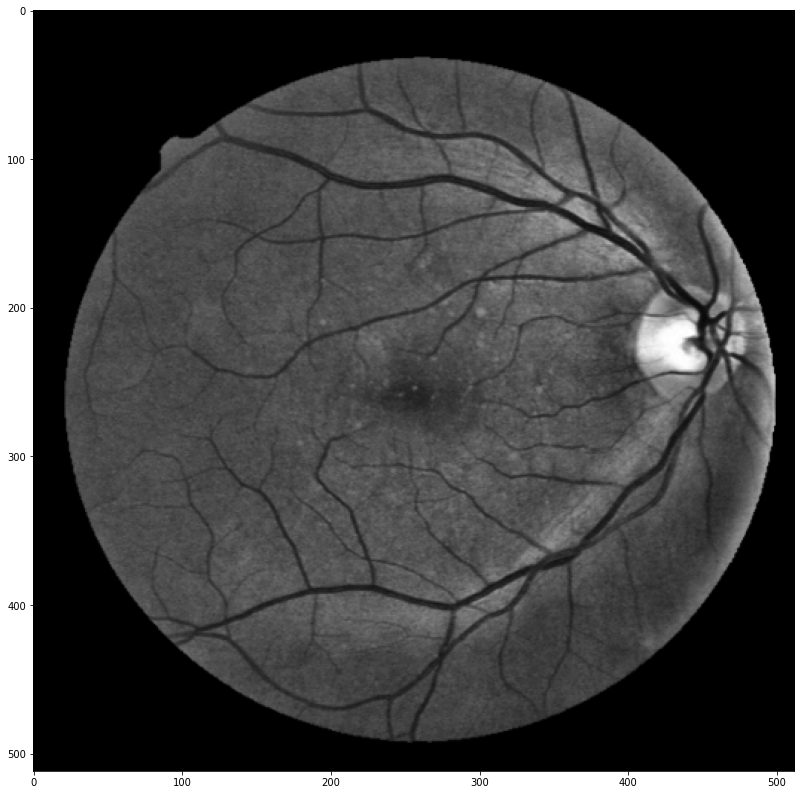

In [9]:
ds = DriveDataset('/pghbio/dbmi/batmanlab/rohit33/DRIVE/', toy=False, disk_size=6)
i = ds[1]
plt.figure(figsize=(14, 14))
# plt.imshow(i['image'][0] > 0.1, 'gray')
plt.imshow(i['image'][0], 'gray')

In [84]:
i = i['image'][0]
print(i.min(), i.max())

tensor(0.0013) tensor(1.)
